In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [61]:
UNIT = 't'

START_DATE = datetime(2016, 4, 20)
END_DATE = datetime(2020, 4, 20)

START_DATE = datetime(2016, 1, 31)
END_DATE = datetime(2020, 1, 31)

DATE_RANGE = pd.date_range(START_DATE, END_DATE)

# Pre-defined functions / variables

In [28]:
# Find Crude/Condensates ID, ensuring its uniqueness
crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
assert len(crude_and_condensates) == 1

2020-04-20 13:43:40,955 vortexasdk.operations — INFO — Searching Products with params: {'term': ['crude'], 'ids': [], 'product_parent': [], 'allowTopLevelProducts': True}
2020-04-20 13:43:41,146 vortexasdk.client — INFO — 18 Results to retreive. Sending 1 post requests in parallel using 6 threads.


In [29]:
def load_nymex_future_prices_from_EIA():
    future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
    future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
    return future_prices

In [30]:
def load_spot_prices_from_EIA():
    spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
    spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
    return spot_prices

In [31]:
def plot_floating_storage(floating_storage):
    floating_storage.plot(title='Global crude oil floating storage', grid=True)
    plt.xlabel('date')
    plt.ylabel('k' + UNIT);

In [32]:
def plot_prices(prices, title):
    prices.plot(title=title, grid=True)
    plt.xlabel('date')
    plt.ylabel('USD');    

In [33]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot('211')
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot('210')
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')

# Load Data

In [34]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):    
    
    df = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    df = df.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    

    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    
    return df

In [35]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs.head()

2020-04-20 13:43:42,057 vortexasdk.operations — INFO — Searching CargoTimeSeries with params: {'filter_activity': 'storing_state', 'filter_time_min': '2016-01-31T00:00:00.000Z', 'filter_time_max': '2020-01-31T00:00:00.000Z', 'timeseries_activity_time_span_min': None, 'timeseries_activity_time_span_max': None, 'filter_charterers': [], 'filter_owners': [], 'filter_products': ['54af755a090118dcf9b0724c9a4e9f14745c26165385ffa7f1445bc768f06f11'], 'filter_vessels': [], 'filter_destinations': [], 'filter_origins': [], 'filter_storage_locations': [], 'filter_ship_to_ship_locations': [], 'filter_waypoints': [], 'disable_geographic_exclusion_rules': True, 'timeseries_frequency': 'day', 'timeseries_unit': 't', 'timeseries_activity': 'storing_state', 'size': 500}


,date,t,number_of_cargo_movements
0,2016-01-31,7414037,106
1,2016-02-01,7818785,105
2,2016-02-02,7533256,112
3,2016-02-03,8043671,118
4,2016-02-04,8324692,117


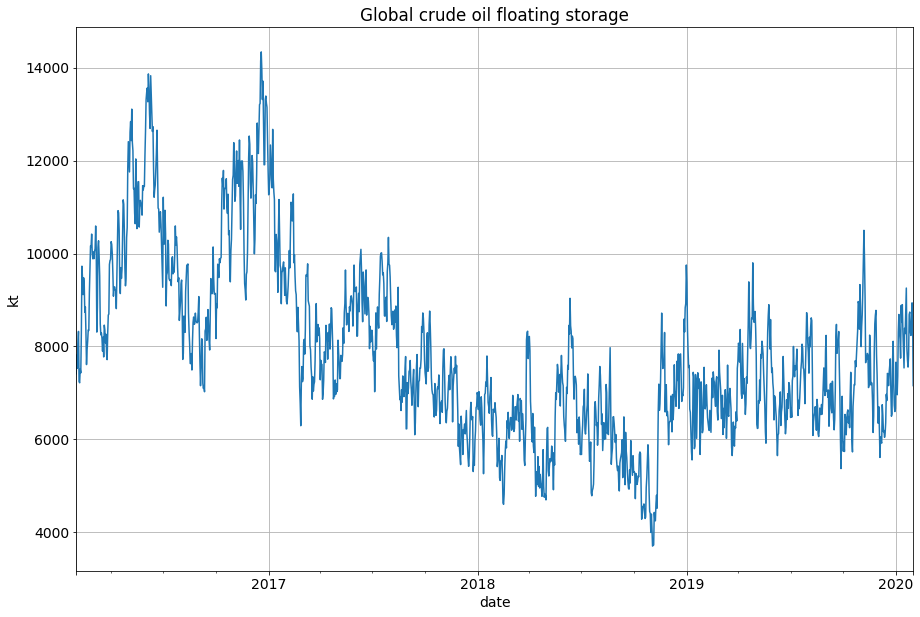

In [36]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
plot_floating_storage(floating_storage)

In [37]:
spot_prices = load_spot_prices_from_EIA()

In [38]:
spot_prices.head()

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2016-01-31,33.66,33.14
2016-02-01,31.62,32.45
2016-02-02,29.90,30.98
2016-02-03,32.29,32.38
2016-02-04,31.63,32.76


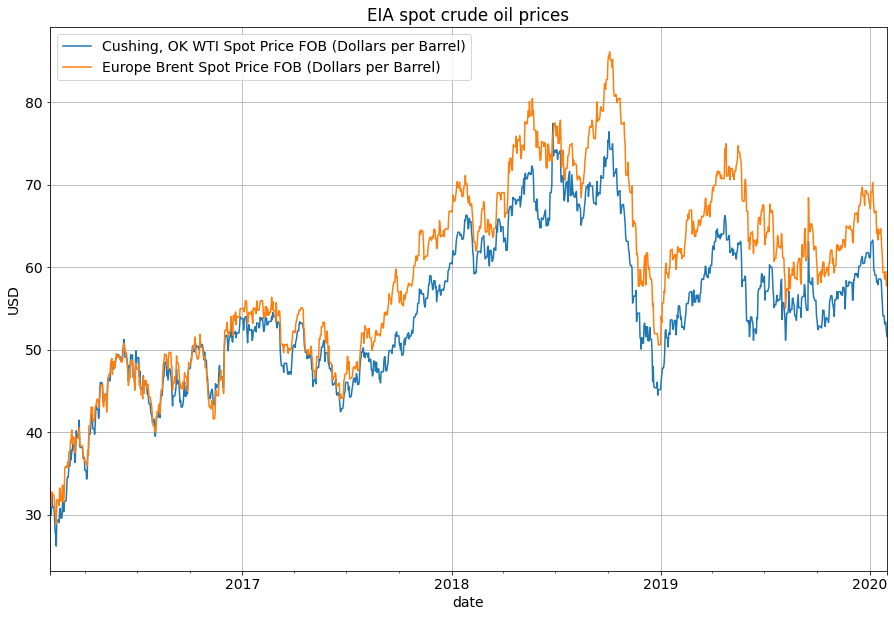

In [39]:
plot_prices(spot_prices, 'EIA spot crude oil prices')

In [50]:
spot_prices = spot_prices['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']

KeyError: 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'

In [51]:
future_prices = load_nymex_future_prices_from_EIA()

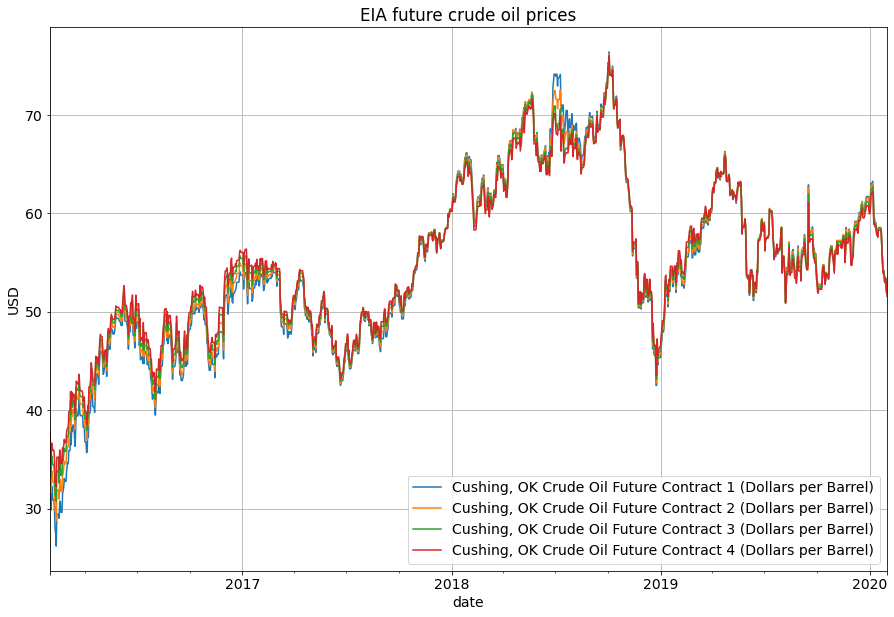

In [52]:
plot_prices(future_prices, 'EIA future crude oil prices')

In [53]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values

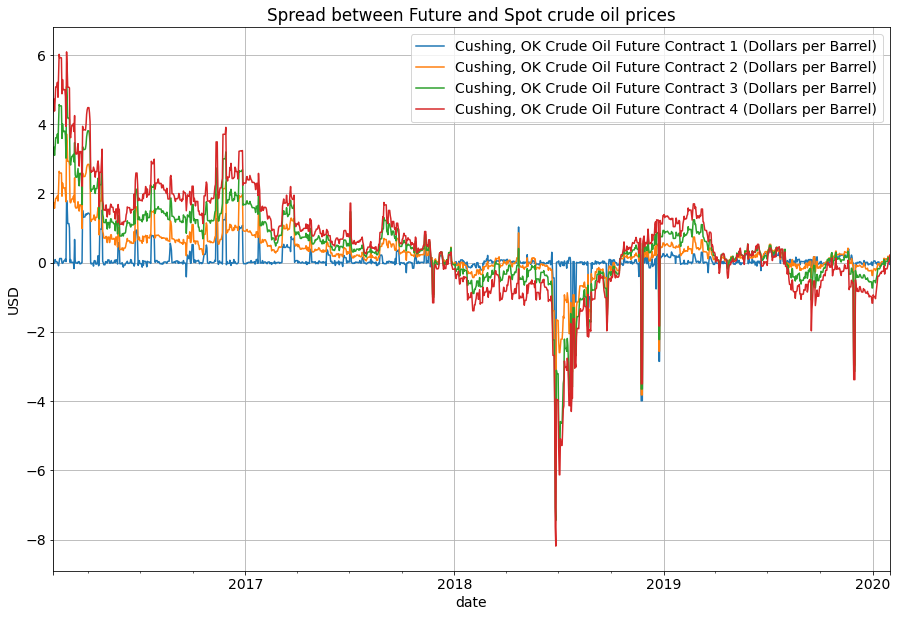

In [54]:
plot_prices(calendar_spread, 'Spread between Future and Spot crude oil prices')

In [45]:
future_prices = future_prices['Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)']
calendar_spread = calendar_spread['Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)']

# Granger causality analysis

In [46]:
MAXLAG = 100

In [47]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.3802 , p=0.0000  , df_denom=1458, df_num=1
ssr based chi2 test:   chi2=18.4181 , p=0.0000  , df=1
likelihood ratio test: chi2=18.3029 , p=0.0000  , df=1
parameter F test:         F=18.3802 , p=0.0000  , df_denom=1458, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.5829  , p=0.0001  , df_denom=1455, df_num=2
ssr based chi2 test:   chi2=19.2317 , p=0.0001  , df=2
likelihood ratio test: chi2=19.1061 , p=0.0001  , df=2
parameter F test:         F=9.5829  , p=0.0001  , df_denom=1455, df_num=2


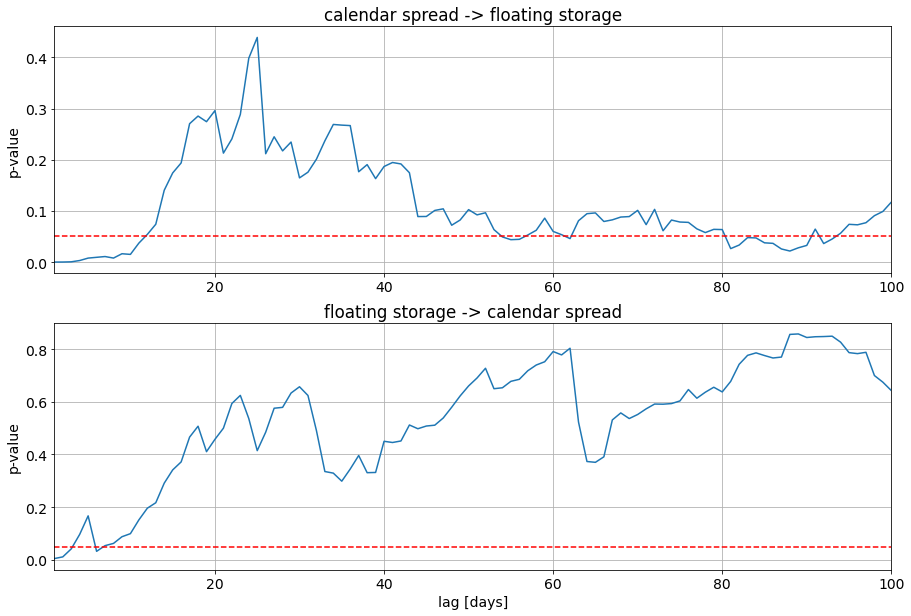

In [48]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

Significant results were found in the top plot, suggesting that calendar spread Granger-causes floating storage both in the short term (1-10 days) and in the long-term (around ~60 days, and 80-90 days). This result was expected, as contango structure in the oil markets creates opportunities to profit by storing crude oil on tankers until prices move higher. The lags might reflect the time it takes to charter a vessel and pick up the cargo.

The bottom plot shows no consistent evidence in the opposite direction (i.e. floating storage Granger-causing calendar spread).


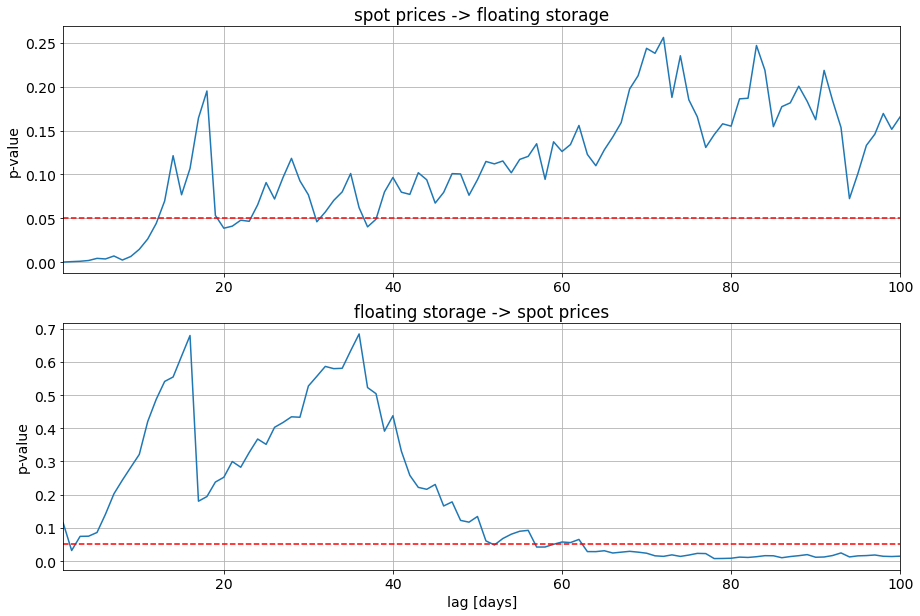

In [55]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

The top plot shows significant evidence for spot prices Granger-causing floating storage in the short term (1-10 days), but no consistent evidence in the long-term. Most importantly, the bottom plot shows **significant evidence that crude oil floating storage Granger-causes spot prices with a lag of 2-3 months**. By the definition of Granger causality, this means that **floating storage may have significant predictive value for spot crude oil prices 2-3 months into the future**.